In [45]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = './'

In [46]:
# DOWNLOAD DATASET DARI KAGGLE
# !kaggle datasets download -d shubhamgoel27/dermnet
# !kaggle datasets download -d artakusuma/basedir
# !kaggle datasets download -d haroonalam16/20-skin-diseases-dataset
# !kaggle datasets download -d syedalinaqvi/augmented-skin-conditions-image-dataset

In [47]:
import zipfile

# Ekstrak dermnet.zip
# with zipfile.ZipFile("20-skin-diseases-dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("Datasetnya")

# Tampilkan isi folder "dataset"
print("Isi folder datasetnya:", os.listdir("SkinData"))

Isi folder datasetnya: ['test', 'train']


In [48]:
#LIBRARIES

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input, BatchNormalization, GlobalAveragePooling2D
from keras.applications import VGG19, ResNet101, MobileNetV2, EfficientNetV2B0
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import datetime

In [49]:
# from tensorflow.keras import mixed_precision

# # Enable mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [50]:
# Definisikan path untuk dataset
base_dir = os.path.join(os.getcwd(), 'SkinData')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [51]:
# Mendapatkan daftar kelas dari folder train
classes = os.listdir(train_dir)

print("Kelas yang ditemukan:", classes)

Kelas yang ditemukan: ['Acne and Rosacea', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis', 'Bullous Disease', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue Diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and Related Diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [52]:
# Menghitung jumlah gambar per kelas
train_counts = {}
test_counts = {}

In [53]:
# Hitung jumlah gambar training
for cls in classes:
    train_class_dir = os.path.join(train_dir, cls)
    train_counts[cls] = len(os.listdir(train_class_dir))

# Hitung jumlah gambar testing
test_dir = os.path.join(base_dir, 'test')
for cls in classes:
    test_class_dir = os.path.join(test_dir, cls)
    test_counts[cls] = len(os.listdir(test_class_dir))

In [54]:
# Tampilkan informasi dataset
print(f"Jumlah kelas: {len(classes)}")
print("\nDaftar kelas dan jumlah gambar:")
for cls in classes:
    print(f"{cls}:")
    print(f"- Training: {train_counts[cls]}")
    print(f"- Testing: {test_counts[cls]}")

print(f"\nTotal gambar training: {sum(train_counts.values())}")
print(f"Total gambar testing: {sum(test_counts.values())}")

Jumlah kelas: 23

Daftar kelas dan jumlah gambar:
Acne and Rosacea:
- Training: 192
- Testing: 20
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions:
- Training: 192
- Testing: 20
Atopic Dermatitis:
- Training: 192
- Testing: 20
Bullous Disease:
- Training: 192
- Testing: 20
Cellulitis Impetigo and other Bacterial Infections:
- Training: 192
- Testing: 20
Eczema:
- Training: 192
- Testing: 20
Exanthems and Drug Eruptions:
- Training: 192
- Testing: 20
Hair Loss Photos Alopecia and other Hair Diseases:
- Training: 192
- Testing: 20
Herpes HPV and other STDs:
- Training: 192
- Testing: 20
Light Diseases and Disorders of Pigmentation:
- Training: 192
- Testing: 20
Lupus and other Connective Tissue Diseases:
- Training: 192
- Testing: 20
Melanoma Skin Cancer Nevi and Moles:
- Training: 192
- Testing: 20
Nail Fungus and other Nail Disease:
- Training: 192
- Testing: 20
Poison Ivy Photos and other Contact Dermatitis:
- Training: 192
- Testing: 20
Psoriasis pictures Lichen Pla

In [55]:
# Data Generator untuk Training dengan Augmentasi Canggih
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',               
    validation_split=0.2  # Untuk membagi data
)

# Data Generator untuk Validasi (Minimal Augmentasi)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training', 
    shuffle=True
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  
    shuffle=False
)

# Load testing data (tanpa subset karena ini hanya untuk testing)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3542 images belonging to 23 classes.
Found 874 images belonging to 23 classes.
Found 460 images belonging to 23 classes.


In [56]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_term = alpha * tf.pow(1 - y_pred, gamma)
        loss = focal_term * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

In [57]:
# Menyimpan informasi penting untuk training
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
test_steps = test_generator.samples // test_generator.batch_size

print(f"Jumlah batch per epoch: {steps_per_epoch}")
print(f"Jumlah batch validasi: {validation_steps}")
print(f"Jumlah batch testing: {test_steps}")

Jumlah batch per epoch: 110
Jumlah batch validasi: 27
Jumlah batch testing: 14


In [58]:
# Konfigurasi model
IMG_SIZE = 224
NUM_CLASSES = 10
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Mendefinisikan input tensor
input_tensor = Input(shape=INPUT_SHAPE)


In [15]:
# # VGG19 model
# vgg19_base = VGG19(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=input_tensor
# )
# # Freeze layer base model 
# for layer in vgg19_base.layers[:15]: 
#     layer.trainable = False

# # Perbaikan pada arsitektur top layers
# vgg19_out = vgg19_base.output 
# vgg19_out = Flatten()(vgg19_out)  
# vgg19_out = Dense(4096, activation='relu', kernel_regularizer=l2(0.001))(vgg19_out)
# vgg19_out = BatchNormalization()(vgg19_out)
# vgg19_out = Dropout(0.5)(vgg19_out)
# vgg19_out = Dense(4096, activation='relu', kernel_regularizer=l2(0.001))(vgg19_out)
# vgg19_out = BatchNormalization()(vgg19_out)
# vgg19_out = Dropout(0.5)(vgg19_out)
# vgg19_out = Dense(NUM_CLASSES, activation='softmax')(vgg19_out)

# # Buat model akhir
# vgg19_model = Model(inputs=vgg19_base.input, outputs=vgg19_out)

In [16]:
# # ResNet101 
# resnet101_base = ResNet101(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=input_tensor
# )

# # Freeze layer base model dengan strategi fine-tuning lebih baik
# for layer in resnet101_base.layers[:10]: 
#     layer.trainable = False

# # Arsitektur top layers dengan optimasi
# resnet101_out = resnet101_base.output
# resnet101_out = GlobalAveragePooling2D()(resnet101_out)
# resnet101_out = Dense(512, activation='relu',)(resnet101_out)
# resnet101_out = BatchNormalization()(resnet101_out)
# resnet101_out = Dropout(0.6)(resnet101_out)
# resnet101_out = Dense(512, activation='relu',)(resnet101_out)
# resnet101_out = BatchNormalization()(resnet101_out)
# resnet101_out = Dropout(0.5)(resnet101_out)
# resnet101_out = Dense(NUM_CLASSES, activation='softmax')(resnet101_out)

# # Buat model akhir
# resnet101_model = Model(inputs=resnet101_base.input, outputs=resnet101_out)

In [17]:
# # MobileNetV2 base model
# mobilenetv2_base = MobileNetV2(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=input_tensor
# )

# # Freeze sebagian besar layer dari MobileNetV2
# for layer in mobilenetv2_base.layers[:100]:  # Freeze hanya sebagian layer awal
#     layer.trainable = False

# # Tambahkan top layers (Custom Layers)
# mobilenetv2_out = mobilenetv2_base.output
# mobilenetv2_out = GlobalAveragePooling2D()(mobilenetv2_out)  # Gantikan Flatten dengan pooling global
# mobilenetv2_out = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(mobilenetv2_out)
# mobilenetv2_out = BatchNormalization()(mobilenetv2_out)
# mobilenetv2_out = Dropout(0.5)(mobilenetv2_out)
# mobilenetv2_out = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(mobilenetv2_out)
# mobilenetv2_out = BatchNormalization()(mobilenetv2_out)
# mobilenetv2_out = Dropout(0.5)(mobilenetv2_out)

# # Buat model akhir
# mobilenetv2_model = Model(inputs=mobilenetv2_base.input, outputs=mobilenetv2_out)

In [59]:
# EfficientNetV2 base model
efficientnetv2_base = EfficientNetV2B0(
    weights='imagenet',          
    include_top=False,           
    input_tensor=input_tensor    
)

# Freeze sebagian besar layer dari EfficientNetV2
for layer in efficientnetv2_base.layers[:100]:  
    layer.trainable = False

# Feature Extraction
    efficientnetv2_out = efficientnetv2_base.output
    efficientnetv2_out = GlobalAveragePooling2D()(efficientnetv2_out)
    
    # Enhanced Dense Layers with More Regularization
    efficientnetv2_out = Dense(
        1024, 
        activation='relu', 
        kernel_regularizer=l2(0.001),
        kernel_initializer='he_normal'
    )(efficientnetv2_out)
    efficientnetv2_out = BatchNormalization()(efficientnetv2_out)
    efficientnetv2_out = Dropout(0.5)(efficientnetv2_out)
    
    efficientnetv2_out = Dense(
        512, 
        activation='relu', 
        kernel_regularizer=l2(0.001),
        kernel_initializer='he_normal'
    )(efficientnetv2_out)
    efficientnetv2_out = BatchNormalization()(efficientnetv2_out)
    efficientnetv2_out = Dropout(0.5)(efficientnetv2_out)

    # Output Layer
    output = Dense(
        NUM_CLASSES, 
        activation='softmax', 
        kernel_regularizer=l2(0.001)
    )(efficientnetv2_out)

# Buat model akhir
efficientnetv2_model = Model(inputs=efficientnetv2_base.input, outputs=efficientnetv2_out)


In [60]:
# Concatenate outputs
combined = Concatenate()([efficientnetv2_out])
ensemble_out = Dense(NUM_CLASSES, activation='softmax')(combined)

# Membuat model
model = Model(inputs=input_tensor, outputs=ensemble_out)



In [61]:
from sklearn.utils.class_weight import compute_class_weight

# Add this function before model compilation
def get_class_weights(generator):
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(generator.classes), 
        y=generator.classes
    )
    return dict(enumerate(class_weights))

# Get class weights
class_weights = get_class_weights(train_generator)

In [62]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Create learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

In [63]:
# Compile model
optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [64]:
# Tampilkan ringkasan model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 7,767,130 (29.63 MB)

 Trainable params: 7,000,394 (26.70 MB)

 Non-trainable params: 766,736 (2.92 MB)

In [24]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [65]:
from tensorflow.keras.models import load_model

# Definisikan folder untuk menyimpan model
MODEL_PATH = os.path.join(os.getcwd(), 'skin_disease_model_efficientnetv2fulldata')

# Membuat folder jika belum ada
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print(f"Folder penyimpanan dibuat di: {MODEL_PATH}")
else:
    print(f"Folder penyimpanan sudah ada di: {MODEL_PATH}")

# Path untuk file model
model_file_path = os.path.join(MODEL_PATH, 'ensemble_model.h5')

Folder penyimpanan dibuat di: d:\UNS\Bangkit ML\PROJECT\skin_disease_model_efficientnetv2fulldata


In [66]:
# Custom SafeModelCheckpoint
class SafeModelCheckpoint(ModelCheckpoint):
    def _get_file_path(self, epoch, batch, logs):
        try:
            return super()._get_file_path(epoch, batch, logs)
        except KeyError as e:
            print(f"KeyError in filepath formatting: {e}")
            return os.path.join(MODEL_PATH, f'skin_disease_model_epoch_{epoch:02d}.weights.h5')

In [67]:
callbacks = [
    # # Reduce learning rate
    # ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,
    #     patience=5,
    #     min_lr=1e-5,
    #     verbose=1
    # ),

    # Save model checkpoint safely
    ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH, 'skin_disease_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras'),
        monitor='val_loss',  
        save_best_only=True,
        save_weights_only=False,
        mode='min',  
        verbose=1
    ),

    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001, 
        mode='min',
        restore_best_weights=True  # Added to restore best weights
    ),

    # Logging to CSV
    CSVLogger(
        os.path.join(MODEL_PATH, 'training_log.csv'),
        append=True
    )
]

In [28]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

In [29]:
# Cek apakah GPU tersedia

if tf.config.list_physical_devices('GPU'):

    print("GPU tersedia!")

else:

    print("GPU tidak tersedia, menggunakan CPU.")

GPU tidak tersedia, menggunakan CPU.


In [30]:
# tf.config.experimental.set_visible_devices([], 'GPU')

In [31]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [68]:
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Train samples: 3542
Validation samples: 874
Test samples: 460


In [ ]:
# print("Class weights:", class_weights)

# class_weights = {k: float(v) for k, v in class_weights.items()}

Class weights: {0: np.float64(0.8264705882352941), 1: np.float64(1.586290322580645), 2: np.float64(0.878125), 3: np.float64(0.7931451612903225), 4: np.float64(0.8195833333333333), 5: np.float64(0.9502415458937198), 6: np.float64(0.768359375), 7: np.float64(1.8913461538461538), 8: np.float64(2.1855555555555557), 9: np.float64(0.8334745762711865)}


In [ ]:
# Training parameters
EPOCHS = 70
INITIAL_EPOCH = 0

# Train model
print("Memulai training pada:", datetime.datetime.now())

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=INITIAL_EPOCH,
    # class_weight=class_weights
)

Memulai training pada: 2024-12-02 18:17:04.951045
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4943 - loss: 3.4519 - precision: 0.5748 - recall: 0.4422
Epoch 1: val_loss improved from inf to 2.94355, saving model to d:\UNS\Bangkit ML\PROJECT\skin_disease_model_efficientnetv2new\skin_disease_model_epoch_01_val_loss_2.9435.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4971 - loss: 3.4484 - precision: 0.5775 - recall: 0.4451 - val_accuracy: 0.8292 - val_loss: 2.9435 - val_precision: 0.9176 - val_recall: 0.7188
Epoch 2/50
 1/61 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.8125 - loss: 2.9659 - precision: 0.8333 - recall: 0.7812
Epoch 2: val_loss improved from 2.94355 to 2.93186, saving model to d:\UNS\Bangkit ML\PROJECT\skin_disease_model_efficientnetv2new\skin_disease_model_epoch_02_val_loss_2.9319.keras
61/61 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.8125 - loss: 2.9659 - precision: 0.8333 - recall: 0.7812 - val_accuracy: 0.8292 - val_loss: 2.93

In [39]:
# Simpan model
print("Menyimpan model...")
model.save(model_file_path)
print("Model berhasil disimpan di:", model_file_path)

Menyimpan model...
Model berhasil disimpan di: d:\UNS\Bangkit ML\PROJECT\skin_disease_model_efficientnetv2new\ensemble_model.h5


In [36]:
# Plot training & validation metrics
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

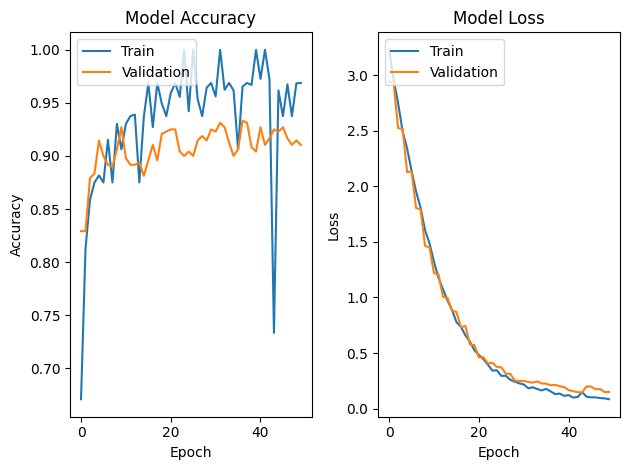

In [40]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [43]:
# Evaluasi model pada test set
print("\nEvaluasi model pada test set:")
results = model.evaluate(test_generator, steps=test_steps)

# Hasil evaluasi
print(f"Test Loss: {results[0]:.4f}")          # Loss
print(f"Test Accuracy: {results[1]:.4f}")      # Accuracy
print(f"Test Precision: {results[2]:.4f}")     # Precision
print(f"Test Recall: {results[3]:.4f}")        # Recall



Evaluasi model pada test set:
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.8613 - loss: 0.3524 - precision: 0.8662 - recall: 0.8588
Test Loss: 0.1831
Test Accuracy: 0.9323
Test Precision: 0.9368
Test Recall: 0.9271



Membuat prediksi...
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step

Classification Report:
                      precision    recall  f1-score   support

                Acne       0.96      0.51      0.67        45
Basal Cell Carcinoma       0.98      0.98      0.98        44
           Carcinoma       1.00      1.00      1.00        74
              Eczema       0.86      0.99      0.92        76
           Keratosis       0.99      1.00      0.99        71
            Melanoma       1.00      0.98      0.99        51
               Milia       0.95      1.00      0.97        72
            Ringworm       1.00      0.82      0.90        51
             Rosacea       0.67      0.98      0.80        42
            Vitiligo       1.00      0.94      0.97        70

            accuracy                           0.93       596
           macro avg       0.94      0.92      0.92       596
        weighted avg       0.95      0.93      0.93       596



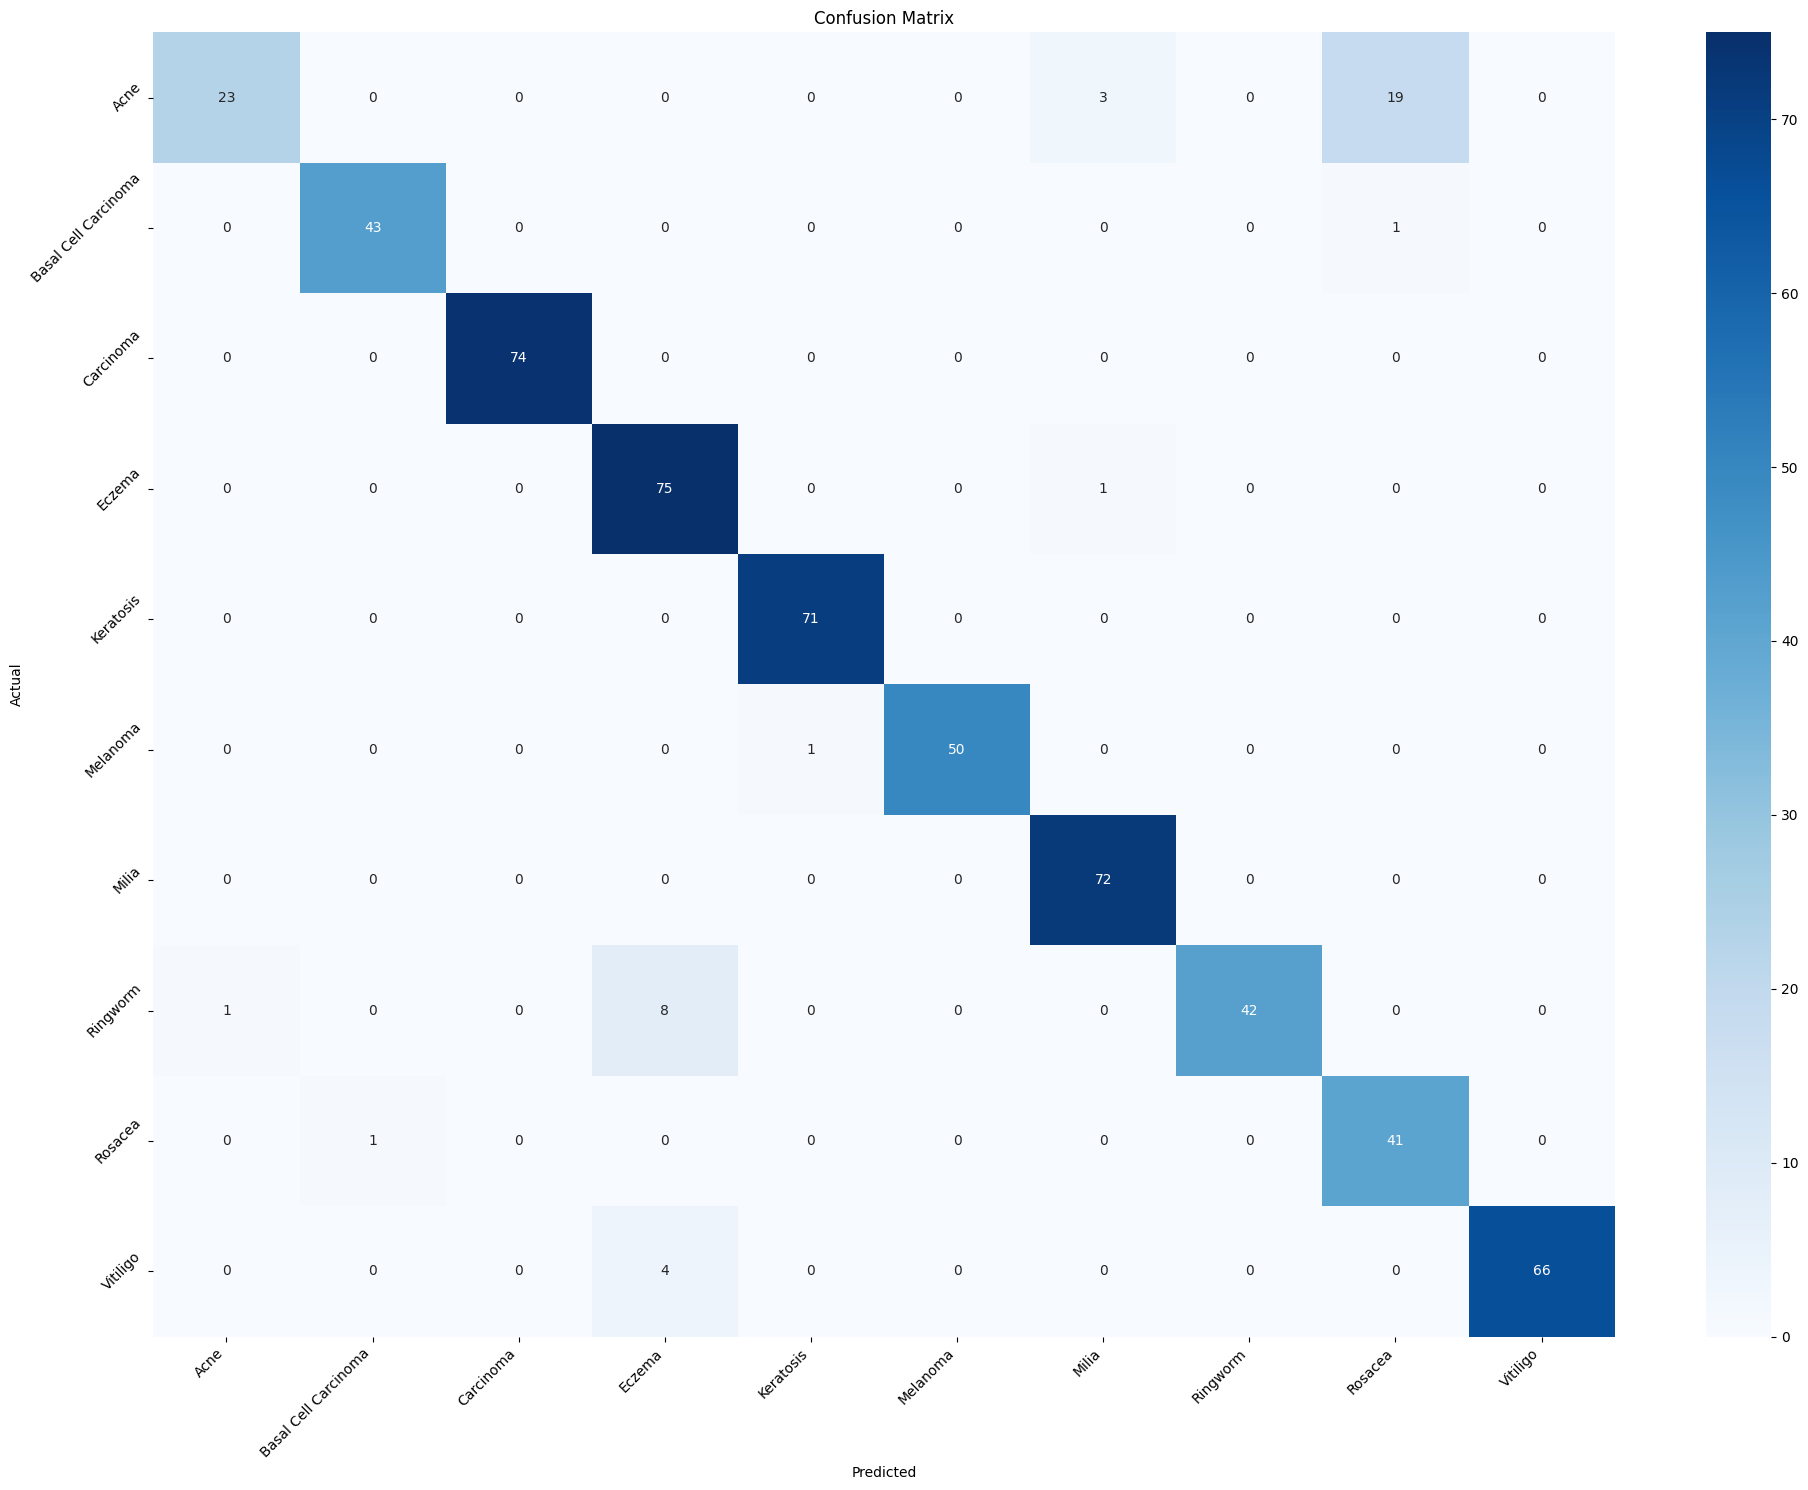


Metrik per kelas:
Acne: 0.5111
Basal Cell Carcinoma: 0.9773
Carcinoma: 1.0000
Eczema: 0.9868
Keratosis: 1.0000
Melanoma: 0.9804
Milia: 1.0000
Ringworm: 0.8235
Rosacea: 0.9762
Vitiligo: 0.9429


In [44]:
# Reset test generator untuk memastikan konsistensi
test_generator.reset()

# Prediksi pada test set
print("\nMembuat prediksi...")
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Validasi panjang array
assert len(true_classes) == len(predicted_classes), \
    f"Panjang tidak sesuai: true_classes={len(true_classes)}, predicted_classes={len(predicted_classes)}"

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
plt.figure(figsize=(20, 15))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

# Simpan confusion matrix
plt.savefig(os.path.join(MODEL_PATH, 'confusion_matrix.png'))
plt.show()

# Tampilkan metrik per kelas
print("\nMetrik per kelas:")
for i, class_name in enumerate(class_labels):
    class_predictions = predicted_classes == i
    class_true = true_classes == i
    class_accuracy = np.sum(class_predictions & class_true) / np.sum(class_true)
    print(f"{class_name}: {class_accuracy:.4f}")
